In [23]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader
from PIL import Image
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [24]:
root = "/kaggle/input/project1/leaf/train"

plants = sorted(os.listdir(root))

image_paths = []
plant_labels = []
disease_labels = []

for plant in plants:
    plant_path = os.path.join(root, plant)
    diseases = sorted(os.listdir(plant_path))
    
    for disease in diseases:
        disease_folder = os.path.join(plant_path, disease)
        for img in os.listdir(disease_folder):
            image_paths.append(os.path.join(disease_folder, img))
            plant_labels.append(plant)
            disease_labels.append(disease)

df = pd.DataFrame({
    "image": image_paths,
    "plant": plant_labels,
    "disease": disease_labels
})

print(df.head())
print("Total images:", len(df))


                                               image  plant    disease
0  /kaggle/input/project1/leaf/train/apple/Black_...  apple  Black_rot
1  /kaggle/input/project1/leaf/train/apple/Black_...  apple  Black_rot
2  /kaggle/input/project1/leaf/train/apple/Black_...  apple  Black_rot
3  /kaggle/input/project1/leaf/train/apple/Black_...  apple  Black_rot
4  /kaggle/input/project1/leaf/train/apple/Black_...  apple  Black_rot
Total images: 88013


In [25]:
plant_encoder = LabelEncoder()
disease_encoder = LabelEncoder()

df["plant_id"] = plant_encoder.fit_transform(df["plant"])
df["disease_id"] = disease_encoder.fit_transform(df["disease"])

num_plants = len(plant_encoder.classes_)
num_diseases = len(disease_encoder.classes_)

print("Plants:", plant_encoder.classes_)
print("Diseases:", disease_encoder.classes_)
print("Num plants:", num_plants)
print("Num diseases:", num_diseases)

Plants: ['apple' 'banana' 'corn' 'guava' 'lime' 'potato' 'tomato']
Diseases: ['Algal_Leaf_Spot' 'Bacterial_spot' 'Black_Spot' 'Black_rot'
 'Cedar_apple_rust' 'Cercospora_leaf_spot Gray_leaf_spot' 'Citrus_Canker'
 'Citrus_Pest' 'Citrus_Scab' 'Common_rust' 'Early_blight' 'Greening'
 'Healthy_Leaf' 'Late_blight' 'Leaf_Curl' 'Leaf_Mold'
 'Northern_Leaf_Blight' 'Septoria_leaf_spot'
 'Spider_mites Two-spotted_spider_mite' 'Target_Spot'
 'Tomato_Yellow_Leaf_Curl_Virus' 'Tomato_mosaic_virus' 'Yellow_Spot'
 'anthracnose' 'cordana' 'fresh' 'healthy' 'insect_bite' 'multiple'
 'pestalotiopsis' 'scab' 'scorch' 'sigatoka' 'yld']
Num plants: 7
Num diseases: 34


In [26]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

class LeafDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image"]).convert("RGB")
        if self.transform: 
            img = self.transform(img)
        
        return img, row["plant_id"], row["disease_id"]

dataset = LeafDataset(df, transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

print("Dataset ready!")


Dataset ready!


In [28]:
class MultiOutputEfficientNet(nn.Module):
    def __init__(self, num_plants, num_diseases):
        super().__init__()
        self.base = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        
        # remove final classifier
        self.base.classifier = nn.Identity()
        
        self.fc_plant = nn.Linear(1280, num_plants)
        self.fc_disease = nn.Linear(1280, num_diseases)
        
    def forward(self, x):
        feats = self.base(x)
        out_plant = self.fc_plant(feats)
        out_disease = self.fc_disease(feats)
        return out_plant, out_disease

model = MultiOutputEfficientNet(num_plants, num_diseases).to(device)

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for imgs, plant, disease in tqdm(loader):
        imgs, plant, disease = imgs.to(device), plant.to(device), disease.to(device)

        optimizer.zero_grad()

        out_plant, out_disease = model(imgs)

        loss1 = criterion(out_plant, plant)
        loss2 = criterion(out_disease, disease)

        loss = loss1 + loss2
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss/len(loader):.4f}")

  3%|▎         | 78/2751 [00:09<05:34,  8.00it/s]


KeyboardInterrupt: 

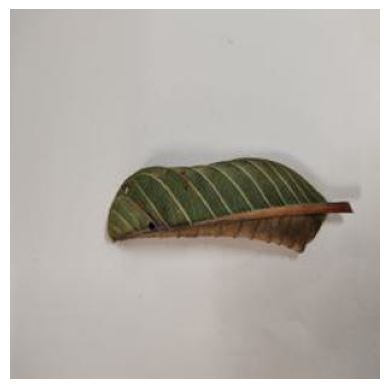

===== KẾT QUẢ =====
Loại cây thực : guava
Loại cây dự đoán: guava

Bệnh thực     : scorch
Bệnh dự đoán  : scorch


In [20]:
import random
import matplotlib.pyplot as plt

idx = random.randint(0, len(df)-1)
row = df.iloc[idx]

img = Image.open(row["image"]).convert("RGB")
plt.imshow(img)
plt.axis("off")
plt.show()

x = transform(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    out_plant, out_disease = model(x)
    pred_plant = out_plant.argmax(1).item()
    pred_dis = out_disease.argmax(1).item()

print("===== KẾT QUẢ =====")
print("Loại cây thực :", row["plant"])
print("Loại cây dự đoán:", plant_encoder.inverse_transform([pred_plant])[0])
print()
print("Bệnh thực     :", row["disease"])
print("Bệnh dự đoán  :", disease_encoder.inverse_transform([pred_dis])[0])
